<a href="https://colab.research.google.com/github/EtornamAmetsi/waspassignment2/blob/main/assignment_ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Jingwei Hu, Tianru Zhang, David Vävinggren

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Fill in</font>

- **Team ID:** <font color='red'>Fill in</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health.
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam.


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/54581/assignments

**Due Date:** August 22, 2025.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks.

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long.

In [4]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [5]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [6]:
# Import
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels.
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [7]:
# 1. Download dataset
file_name = Path("codesubset.tar.gz")

if not file_name.exists():
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

In [8]:
# 1. unzip the downloaded data set folder
file_name = Path('codesubset')
if not file_name.exists():
    !tar -xf codesubset.tar.gz

Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [9]:
# 2. clone the code files for data preprocessing
file_name = Path('ecg-preprocessing')
if not file_name.exists():
    !git clone https://github.com/paulhausner/ecg-preprocessing.git

Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

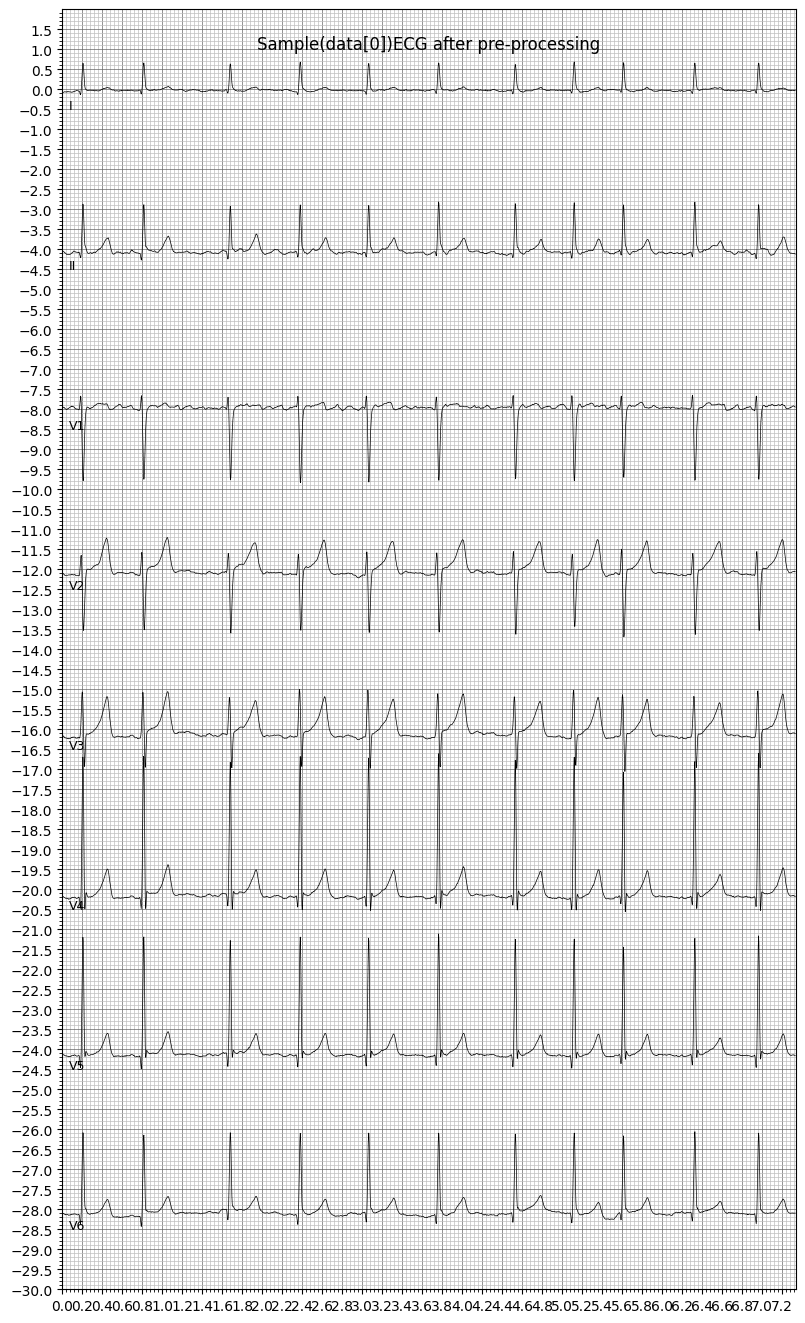

In [10]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample(data[0])ECG after pre-processing')
plt.show()

#


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "face

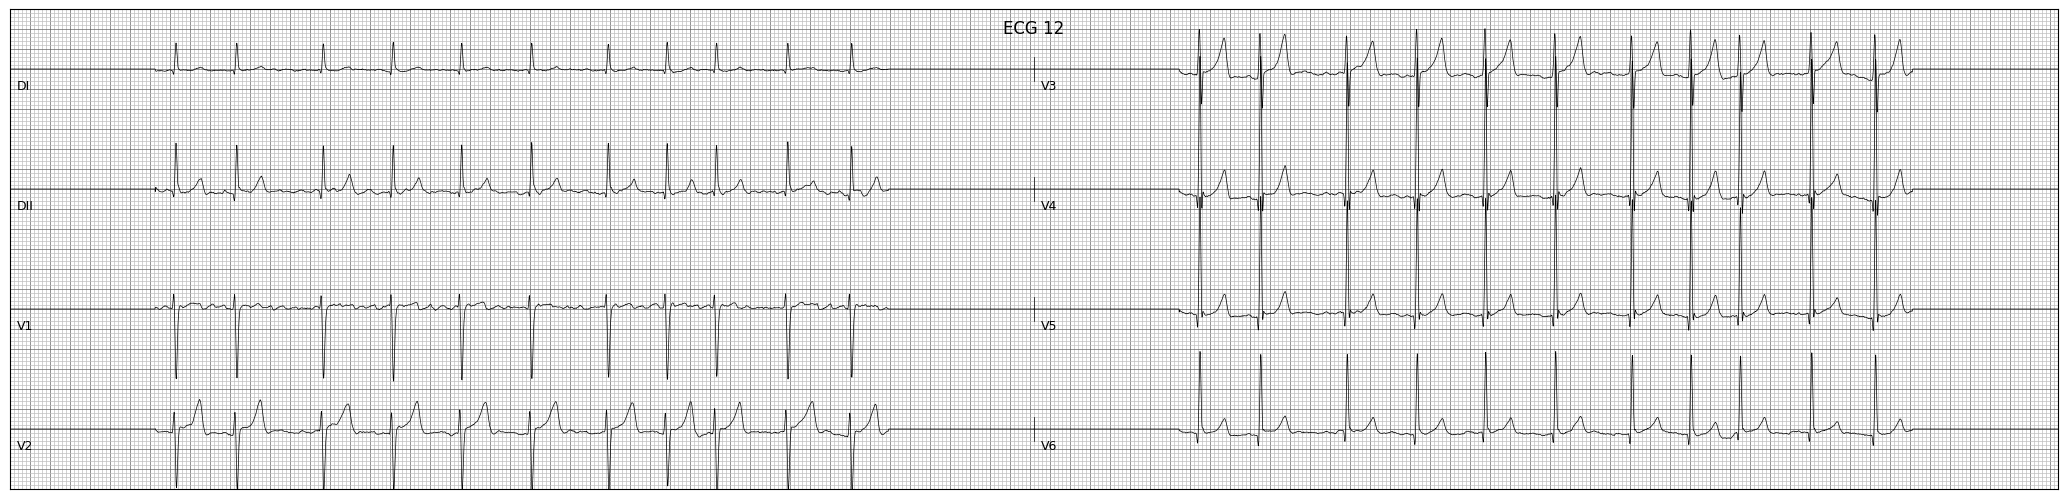

<Figure size 640x480 with 0 Axes>

In [11]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8.
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [12]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

codesubset/train.h5 already exits. Using cached. Delete it manually to recieve it again!
codesubset/test.h5 already exits. Using cached. Delete it manually to recieve it again!


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


(10000, 4096, 8)
(4096, 8)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "face

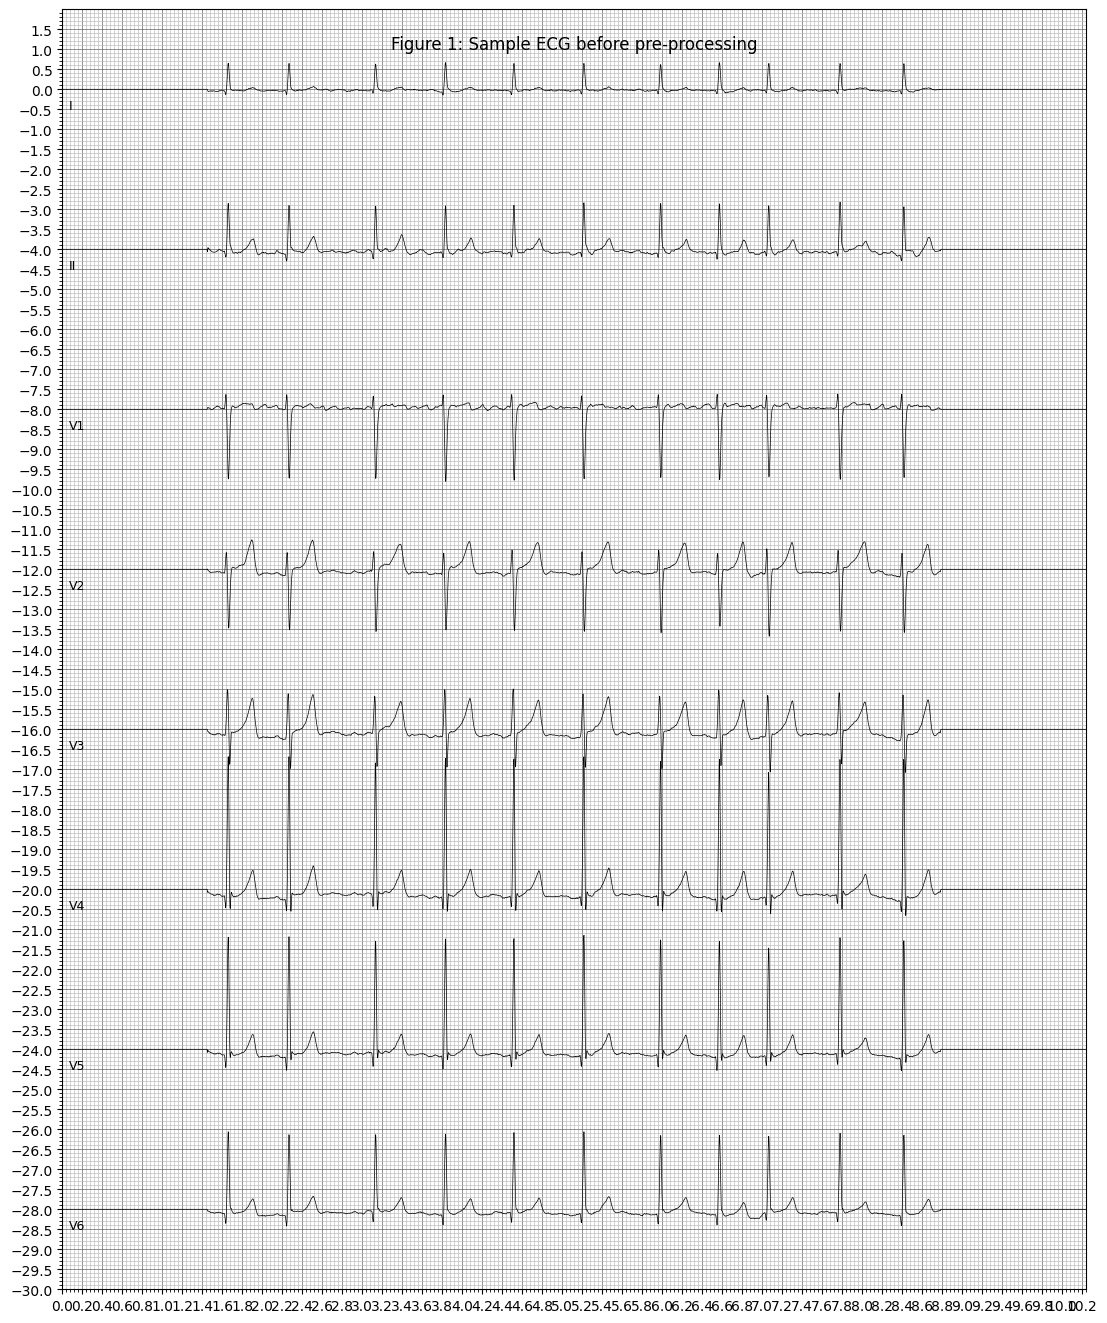

Distribution of Atrial Fibrillation (AF) in the dataset:
AF
0    7000
1    3000
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

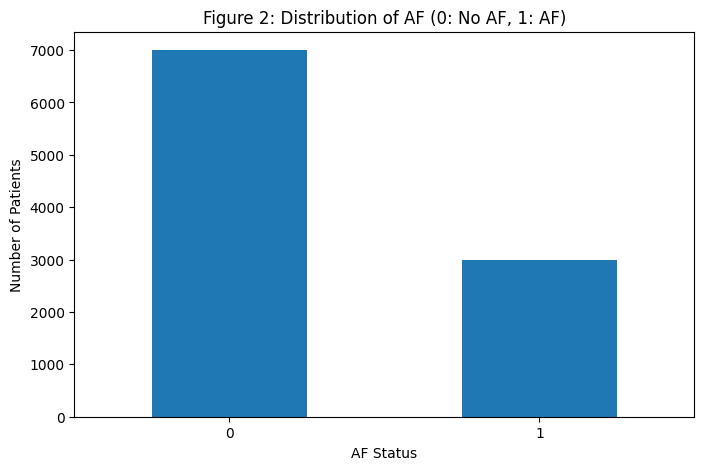

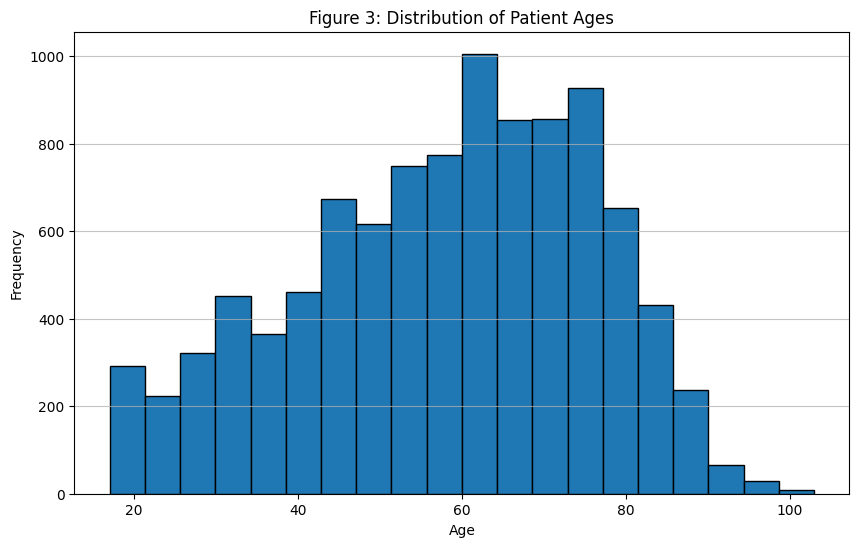

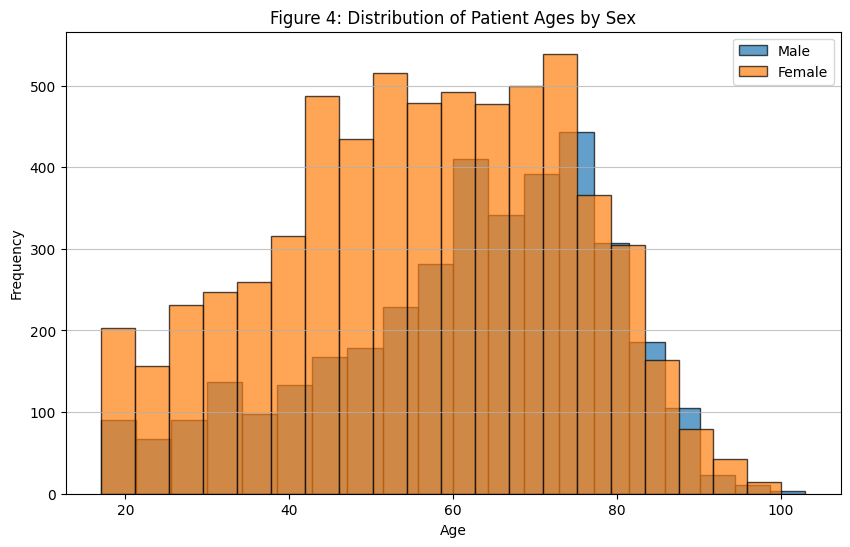

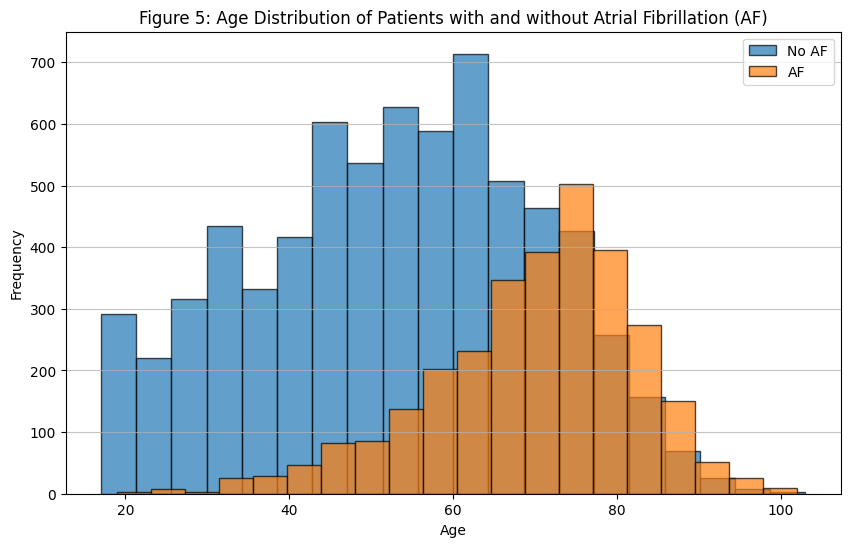

'\nEnd of our code.\n'

In [13]:
"""
TASK: Insert your code here
"""

import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
print(data.shape)
print(data[1].shape)


#Plot for an ECG example after preprocessing
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(data[0].T, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Figure 1: Sample ECG before pre-processing')
plt.show()

#Reading patient data from csv
patient_data = pd.read_csv('codesubset/train.csv')

#To check balance of dataset, we do plot the distribution of Atrial Fibrillation (AF) in the dataset
af_counts = patient_data['AF'].value_counts()
print("Distribution of Atrial Fibrillation (AF) in the dataset:")
print(af_counts)

# You can also visualize this with a bar plot
plt.figure(figsize=(8, 5))
af_counts.plot(kind='bar')
plt.title('Figure 2: Distribution of AF (0: No AF, 1: AF)')
plt.xlabel('AF Status')
plt.ylabel('Number of Patients')
plt.xticks(rotation=0)
plt.show()

#Evaluating the distribution of age and sex of the patients using histograms

plt.figure(figsize=(10, 6))
plt.hist(patient_data['age'], bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Figure 3: Distribution of Patient Ages')
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(patient_data[patient_data['sex'] == 'M']['age'], bins=20, edgecolor='black', alpha=0.7, label='Male')
plt.hist(patient_data[patient_data['sex'] == 'F']['age'], bins=20, edgecolor='black', alpha=0.7, label='Female')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Figure 4: Distribution of Patient Ages by Sex')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

#Evaluating the distribution of patients with and without Atrial Fibrillation (AF)

plt.figure(figsize=(10, 6))
plt.hist(patient_data[patient_data['AF'] == 0]['age'], bins=20, edgecolor='black', alpha=0.7, label='No AF')
plt.hist(patient_data[patient_data['AF'] == 1]['age'], bins=20, edgecolor='black', alpha=0.7, label='AF')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Figure 5: Age Distribution of Patients with and without Atrial Fibrillation (AF)')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

"""
End of our code.
"""

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />


**<font color='red'>Your explanation here:</font>**

What preprocessing does and why it is necessary :
  * The data is resampled at 400HZ so that it captures important frequencies while reducing computational cost and keeping the data volume managable. It is a standard proceedure according to the National Instituite of Health(NIH) and GE Healthcare.
  * Some signals had different durations and in order to make them all have the same sizes, zero-padding was done.
  * According to the original [article](https://www.nature.com/articles/s41467-020-15432-4), removing trends in ECG signals/removing possible powerline noise was done because noise and interference in the baseline are established causes of error and affects both automatic and manual diagnosis of ECG abnomalities.



Main findings from our data analysis:
  * We checked the balance of the dataset by  examining the distribution of the target variable AF in figure 2. The distribution shows that there are more patients without AF than patients with AF and this could be a point of concern for training.

  * We also evaluated the distribution of the ages and sexs of patients in using histograms in figure 3 and 4. We noticed that there are more female patients than males(fig3) and the majority of patients are between 40 to 80 years old.

  * We analysed the age distribution of patients with and without Atrial Fibrillation (AF) in figure 5 and noticed that more older patients tend to have AF than younger ones.






---
## Model

The model class consists of two methods:
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations:
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [14]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [15]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        """
        TASK: Replace the baseline model with your model; Insert your code here
        """
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128)
        self.conv1 = nn.Conv1d(in_channels=8,
                              out_channels=32,
                              kernel_size=self.kernel_size,
                              stride=downsample,
                              padding=self._padding(downsample),
                              bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                            out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))
        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x
        """
        End of our code.
        """

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**


---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [35]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """
        optimizer.zero_grad()
        output = model(traces)
        loss = loss_function(output, diagnoses)
        loss.backward()
        optimizer.step()

        """
        End of our code.
        """

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    print(f'loss:{total_loss/32}')
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [30]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_probs = []  # accumulated predicted probabilities
    valid_true = [] # accumulated true labels

    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """
        with torch.no_grad():
          output = model(traces)
          loss = loss_function(output, diagnoses) # Assuming diagnoses is a single column tensor and output is too

          # Collect true labels and predicted probabilities
          valid_true.extend(diagnoses.cpu().numpy())
          # Assuming output is logit for binary classification, extend with the raw output
          valid_probs.extend(output.squeeze(1).cpu().numpy())

        """
        End of our code.
        """

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_probs), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**


In [39]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 100
batch_size = 32

In [19]:
from torch.utils.data import TensorDataset, random_split, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""
train_size = int(0.8 * len_dataset)
valid_size = len_dataset - train_size
dataset_train, dataset_valid = random_split(dataset, [train_size, valid_size])
"""
End of our code.
"""

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

Use device: cuda

Building data loaders...
Done!



Define model...
Done!

Define optimiser...
Done!

Training...


  0%|          | 0/100 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

loss:4.611628876067698


Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.018447 	Valid Loss 0.016805 	AUROC 0.7696 	AP 0.5784 	F1 0.2374 	Best model -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.9686887953430414


Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.015875 	Valid Loss 0.016014 	AUROC 0.7954 	AP 0.5953 	F1 0.4424 	Best model -> saved


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.8168555591255426


Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.015267 	Valid Loss 0.015743 	AUROC 0.8011 	AP 0.6188 	F1 0.4369 	Best model -> saved


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.7340237153694034


Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.014936 	Valid Loss 0.015659 	AUROC 0.8037 	AP 0.6185 	F1 0.4650 	Best model -> saved


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.704552830196917


Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.014818 	Valid Loss 0.015647 	AUROC 0.8058 	AP 0.6163 	F1 0.4746 	Best model -> saved


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.6664315573871136


Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.014666 	Valid Loss 0.016415 	AUROC 0.8094 	AP 0.6055 	F1 0.5872 	


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.6635713186115026


Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.014654 	Valid Loss 0.015715 	AUROC 0.8074 	AP 0.6120 	F1 0.5227 	


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.6418809182941914


Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.014568 	Valid Loss 0.015612 	AUROC 0.8046 	AP 0.6129 	F1 0.4384 	Best model -> saved


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.637775327078998


Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.014551 	Valid Loss 0.015541 	AUROC 0.8079 	AP 0.6187 	F1 0.4783 	Best model -> saved


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.627975315786898


Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.014512 	Valid Loss 0.015773 	AUROC 0.8084 	AP 0.6122 	F1 0.5445 	


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.616013426333666


Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.014464 	Valid Loss 0.015620 	AUROC 0.8040 	AP 0.6266 	F1 0.4213 	


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.626774411648512


Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.014507 	Valid Loss 0.015704 	AUROC 0.8113 	AP 0.6157 	F1 0.5250 	


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.605215740390122


Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.014421 	Valid Loss 0.015683 	AUROC 0.8050 	AP 0.6132 	F1 0.4847 	


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5987302819266915


Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.014395 	Valid Loss 0.015639 	AUROC 0.8083 	AP 0.6151 	F1 0.4984 	


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.6028725262731314


Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.014411 	Valid Loss 0.015570 	AUROC 0.8100 	AP 0.6208 	F1 0.4935 	


Training Epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.600443501956761


Evaluation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16: 	Train Loss 0.014402 	Valid Loss 0.015541 	AUROC 0.8095 	AP 0.6220 	F1 0.4686 	


Training Epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5900401677936316


Evaluation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17: 	Train Loss 0.014360 	Valid Loss 0.015568 	AUROC 0.8065 	AP 0.6192 	F1 0.4331 	


Training Epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.582505624741316


Evaluation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18: 	Train Loss 0.014330 	Valid Loss 0.015718 	AUROC 0.8091 	AP 0.6150 	F1 0.5294 	


Training Epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5874488977715373


Evaluation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19: 	Train Loss 0.014350 	Valid Loss 0.015737 	AUROC 0.8098 	AP 0.6114 	F1 0.5348 	


Training Epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5735128903761506


Evaluation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20: 	Train Loss 0.014294 	Valid Loss 0.015575 	AUROC 0.8066 	AP 0.6208 	F1 0.4839 	


Training Epoch 21:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.574067053385079


Evaluation Epoch 21:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21: 	Train Loss 0.014296 	Valid Loss 0.015567 	AUROC 0.8117 	AP 0.6149 	F1 0.4968 	


Training Epoch 22:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.58089713845402


Evaluation Epoch 22:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22: 	Train Loss 0.014324 	Valid Loss 0.015739 	AUROC 0.8107 	AP 0.6142 	F1 0.5241 	


Training Epoch 23:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.56723468657583


Evaluation Epoch 23:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23: 	Train Loss 0.014269 	Valid Loss 0.015529 	AUROC 0.8119 	AP 0.6209 	F1 0.4913 	Best model -> saved


Training Epoch 24:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.581898970529437


Evaluation Epoch 24:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24: 	Train Loss 0.014328 	Valid Loss 0.015500 	AUROC 0.8077 	AP 0.6251 	F1 0.4403 	Best model -> saved


Training Epoch 25:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5682599181309342


Evaluation Epoch 25:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25: 	Train Loss 0.014273 	Valid Loss 0.015512 	AUROC 0.8098 	AP 0.6183 	F1 0.4669 	


Training Epoch 26:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5665715597569942


Evaluation Epoch 26:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26: 	Train Loss 0.014266 	Valid Loss 0.015644 	AUROC 0.8100 	AP 0.6133 	F1 0.5096 	


Training Epoch 27:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.581001738086343


Evaluation Epoch 27:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27: 	Train Loss 0.014324 	Valid Loss 0.015730 	AUROC 0.8098 	AP 0.6150 	F1 0.5277 	


Training Epoch 28:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.575219191610813


Evaluation Epoch 28:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28: 	Train Loss 0.014301 	Valid Loss 0.015672 	AUROC 0.8121 	AP 0.6126 	F1 0.5247 	


Training Epoch 29:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5628214282914996


Evaluation Epoch 29:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29: 	Train Loss 0.014251 	Valid Loss 0.015567 	AUROC 0.8089 	AP 0.6212 	F1 0.4946 	


Training Epoch 30:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.568664195947349


Evaluation Epoch 30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30: 	Train Loss 0.014275 	Valid Loss 0.015485 	AUROC 0.8106 	AP 0.6209 	F1 0.4538 	Best model -> saved


Training Epoch 31:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5610230369493365


Evaluation Epoch 31:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31: 	Train Loss 0.014244 	Valid Loss 0.015563 	AUROC 0.8104 	AP 0.6178 	F1 0.4643 	


Training Epoch 32:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5718721598386765


Evaluation Epoch 32:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32: 	Train Loss 0.014287 	Valid Loss 0.015663 	AUROC 0.8084 	AP 0.6127 	F1 0.4930 	


Training Epoch 33:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.564235847443342


Evaluation Epoch 33:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33: 	Train Loss 0.014257 	Valid Loss 0.015475 	AUROC 0.8123 	AP 0.6202 	F1 0.4624 	Best model -> saved


Training Epoch 34:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.568310554139316


Evaluation Epoch 34:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34: 	Train Loss 0.014273 	Valid Loss 0.015543 	AUROC 0.8106 	AP 0.6172 	F1 0.4957 	


Training Epoch 35:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.556649641133845


Evaluation Epoch 35:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35: 	Train Loss 0.014227 	Valid Loss 0.015537 	AUROC 0.8101 	AP 0.6220 	F1 0.4946 	


Training Epoch 36:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5639855144545436


Evaluation Epoch 36:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36: 	Train Loss 0.014256 	Valid Loss 0.015894 	AUROC 0.8101 	AP 0.6077 	F1 0.5462 	


Training Epoch 37:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.562703483738005


Evaluation Epoch 37:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37: 	Train Loss 0.014251 	Valid Loss 0.015588 	AUROC 0.8062 	AP 0.6238 	F1 0.3990 	


Training Epoch 38:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.570033395662904


Evaluation Epoch 38:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38: 	Train Loss 0.014280 	Valid Loss 0.015500 	AUROC 0.8123 	AP 0.6234 	F1 0.4812 	


Training Epoch 39:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5602761823683977


Evaluation Epoch 39:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39: 	Train Loss 0.014241 	Valid Loss 0.015424 	AUROC 0.8136 	AP 0.6260 	F1 0.4455 	Best model -> saved


Training Epoch 40:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5537179596722126


Evaluation Epoch 40:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40: 	Train Loss 0.014215 	Valid Loss 0.015526 	AUROC 0.8110 	AP 0.6191 	F1 0.4600 	


Training Epoch 41:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5577391451224685


Evaluation Epoch 41:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41: 	Train Loss 0.014231 	Valid Loss 0.015755 	AUROC 0.8117 	AP 0.6173 	F1 0.5266 	


Training Epoch 42:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5587542969733477


Evaluation Epoch 42:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42: 	Train Loss 0.014235 	Valid Loss 0.015524 	AUROC 0.8100 	AP 0.6191 	F1 0.4875 	


Training Epoch 43:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5527294324710965


Evaluation Epoch 43:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43: 	Train Loss 0.014211 	Valid Loss 0.015559 	AUROC 0.8125 	AP 0.6170 	F1 0.4796 	


Training Epoch 44:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5530996890738606


Evaluation Epoch 44:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44: 	Train Loss 0.014212 	Valid Loss 0.015477 	AUROC 0.8096 	AP 0.6213 	F1 0.4836 	


Training Epoch 45:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.544300992973149


Evaluation Epoch 45:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45: 	Train Loss 0.014177 	Valid Loss 0.015752 	AUROC 0.8108 	AP 0.6125 	F1 0.5517 	


Training Epoch 46:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.557051384821534


Evaluation Epoch 46:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46: 	Train Loss 0.014228 	Valid Loss 0.015618 	AUROC 0.8105 	AP 0.6196 	F1 0.5207 	


Training Epoch 47:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5535144014284015


Evaluation Epoch 47:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47: 	Train Loss 0.014214 	Valid Loss 0.015517 	AUROC 0.8123 	AP 0.6171 	F1 0.5163 	


Training Epoch 48:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5618933476507664


Evaluation Epoch 48:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48: 	Train Loss 0.014248 	Valid Loss 0.015518 	AUROC 0.8145 	AP 0.6210 	F1 0.5080 	


Training Epoch 49:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5531433457508683


Evaluation Epoch 49:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49: 	Train Loss 0.014213 	Valid Loss 0.015450 	AUROC 0.8112 	AP 0.6280 	F1 0.4220 	


Training Epoch 50:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5507909543812275


Evaluation Epoch 50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50: 	Train Loss 0.014203 	Valid Loss 0.015484 	AUROC 0.8085 	AP 0.6306 	F1 0.4115 	


Training Epoch 51:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5492905573919415


Evaluation Epoch 51:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51: 	Train Loss 0.014197 	Valid Loss 0.015821 	AUROC 0.8109 	AP 0.6145 	F1 0.5560 	


Training Epoch 52:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.542918311432004


Evaluation Epoch 52:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52: 	Train Loss 0.014172 	Valid Loss 0.015479 	AUROC 0.8109 	AP 0.6214 	F1 0.4756 	


Training Epoch 53:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.545415874570608


Evaluation Epoch 53:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53: 	Train Loss 0.014182 	Valid Loss 0.015518 	AUROC 0.8109 	AP 0.6194 	F1 0.4831 	


Training Epoch 54:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5531161800026894


Evaluation Epoch 54:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54: 	Train Loss 0.014212 	Valid Loss 0.015491 	AUROC 0.8141 	AP 0.6192 	F1 0.4875 	


Training Epoch 55:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.564746616408229


Evaluation Epoch 55:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55: 	Train Loss 0.014259 	Valid Loss 0.015472 	AUROC 0.8134 	AP 0.6227 	F1 0.5016 	


Training Epoch 56:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.554023184813559


Evaluation Epoch 56:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56: 	Train Loss 0.014216 	Valid Loss 0.015523 	AUROC 0.8077 	AP 0.6267 	F1 0.4062 	


Training Epoch 57:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5515418499708176


Evaluation Epoch 57:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57: 	Train Loss 0.014206 	Valid Loss 0.015493 	AUROC 0.8102 	AP 0.6203 	F1 0.4693 	


Training Epoch 58:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.541905433870852


Evaluation Epoch 58:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58: 	Train Loss 0.014168 	Valid Loss 0.015401 	AUROC 0.8119 	AP 0.6268 	F1 0.4533 	Best model -> saved


Training Epoch 59:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5559267681092024


Evaluation Epoch 59:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59: 	Train Loss 0.014224 	Valid Loss 0.015697 	AUROC 0.8141 	AP 0.6157 	F1 0.5389 	


Training Epoch 60:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5573612288571894


Evaluation Epoch 60:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60: 	Train Loss 0.014229 	Valid Loss 0.015482 	AUROC 0.8118 	AP 0.6232 	F1 0.4591 	


Training Epoch 61:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5528217777609825


Evaluation Epoch 61:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61: 	Train Loss 0.014211 	Valid Loss 0.015474 	AUROC 0.8126 	AP 0.6186 	F1 0.5091 	


Training Epoch 62:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5431116707623005


Evaluation Epoch 62:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62: 	Train Loss 0.014172 	Valid Loss 0.015548 	AUROC 0.8121 	AP 0.6200 	F1 0.5167 	


Training Epoch 63:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.543437368236482


Evaluation Epoch 63:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63: 	Train Loss 0.014174 	Valid Loss 0.015576 	AUROC 0.8112 	AP 0.6221 	F1 0.5151 	


Training Epoch 64:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.542994529940188


Evaluation Epoch 64:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64: 	Train Loss 0.014172 	Valid Loss 0.015606 	AUROC 0.8142 	AP 0.6176 	F1 0.5217 	


Training Epoch 65:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.547467539086938


Evaluation Epoch 65:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65: 	Train Loss 0.014190 	Valid Loss 0.015529 	AUROC 0.8098 	AP 0.6265 	F1 0.4740 	


Training Epoch 66:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5394076043739915


Evaluation Epoch 66:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66: 	Train Loss 0.014158 	Valid Loss 0.015459 	AUROC 0.8099 	AP 0.6254 	F1 0.4513 	


Training Epoch 67:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5399269573390484


Evaluation Epoch 67:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67: 	Train Loss 0.014160 	Valid Loss 0.015482 	AUROC 0.8093 	AP 0.6303 	F1 0.4203 	


Training Epoch 68:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.536241496913135


Evaluation Epoch 68:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68: 	Train Loss 0.014145 	Valid Loss 0.015425 	AUROC 0.8136 	AP 0.6241 	F1 0.4610 	


Training Epoch 69:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.527112646959722


Evaluation Epoch 69:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69: 	Train Loss 0.014108 	Valid Loss 0.015612 	AUROC 0.8135 	AP 0.6159 	F1 0.5254 	


Training Epoch 70:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5579880364239216


Evaluation Epoch 70:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70: 	Train Loss 0.014232 	Valid Loss 0.015371 	AUROC 0.8130 	AP 0.6283 	F1 0.4487 	Best model -> saved


Training Epoch 71:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.527253096923232


Evaluation Epoch 71:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71: 	Train Loss 0.014109 	Valid Loss 0.015598 	AUROC 0.8125 	AP 0.6206 	F1 0.5302 	


Training Epoch 72:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.535462874919176


Evaluation Epoch 72:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72: 	Train Loss 0.014142 	Valid Loss 0.015640 	AUROC 0.8107 	AP 0.6218 	F1 0.5382 	


Training Epoch 73:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.533010419458151


Evaluation Epoch 73:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73: 	Train Loss 0.014132 	Valid Loss 0.015457 	AUROC 0.8105 	AP 0.6228 	F1 0.4264 	


Training Epoch 74:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5374918542802334


Evaluation Epoch 74:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74: 	Train Loss 0.014150 	Valid Loss 0.015448 	AUROC 0.8127 	AP 0.6245 	F1 0.4967 	


Training Epoch 75:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.528755438514054


Evaluation Epoch 75:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75: 	Train Loss 0.014115 	Valid Loss 0.015431 	AUROC 0.8127 	AP 0.6261 	F1 0.4874 	


Training Epoch 76:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5365520948544145


Evaluation Epoch 76:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76: 	Train Loss 0.014146 	Valid Loss 0.015547 	AUROC 0.8151 	AP 0.6191 	F1 0.5358 	


Training Epoch 77:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5311583513394


Evaluation Epoch 77:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77: 	Train Loss 0.014125 	Valid Loss 0.015582 	AUROC 0.8129 	AP 0.6199 	F1 0.5306 	


Training Epoch 78:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.537938511930406


Evaluation Epoch 78:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78: 	Train Loss 0.014152 	Valid Loss 0.015415 	AUROC 0.8109 	AP 0.6272 	F1 0.4483 	


Training Epoch 79:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.527818324044347


Evaluation Epoch 79:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79: 	Train Loss 0.014111 	Valid Loss 0.015451 	AUROC 0.8111 	AP 0.6259 	F1 0.4513 	


Training Epoch 80:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.529164138250053


Evaluation Epoch 80:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80: 	Train Loss 0.014117 	Valid Loss 0.015479 	AUROC 0.8100 	AP 0.6234 	F1 0.4788 	


Training Epoch 81:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.526309534907341


Evaluation Epoch 81:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81: 	Train Loss 0.014105 	Valid Loss 0.015631 	AUROC 0.8101 	AP 0.6181 	F1 0.5261 	


Training Epoch 82:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.529623561538756


Evaluation Epoch 82:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82: 	Train Loss 0.014118 	Valid Loss 0.015461 	AUROC 0.8120 	AP 0.6234 	F1 0.4918 	


Training Epoch 83:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5337857035920024


Evaluation Epoch 83:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83: 	Train Loss 0.014135 	Valid Loss 0.015411 	AUROC 0.8146 	AP 0.6255 	F1 0.4940 	


Training Epoch 84:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5266236197203398


Evaluation Epoch 84:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84: 	Train Loss 0.014106 	Valid Loss 0.015411 	AUROC 0.8128 	AP 0.6267 	F1 0.4434 	


Training Epoch 85:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5257403142750263


Evaluation Epoch 85:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85: 	Train Loss 0.014103 	Valid Loss 0.015418 	AUROC 0.8115 	AP 0.6272 	F1 0.4761 	


Training Epoch 86:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5340670235455036


Evaluation Epoch 86:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86: 	Train Loss 0.014136 	Valid Loss 0.015418 	AUROC 0.8152 	AP 0.6267 	F1 0.5118 	


Training Epoch 87:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5306703690439463


Evaluation Epoch 87:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87: 	Train Loss 0.014123 	Valid Loss 0.015539 	AUROC 0.8134 	AP 0.6190 	F1 0.5187 	


Training Epoch 88:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.530118340626359


Evaluation Epoch 88:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88: 	Train Loss 0.014120 	Valid Loss 0.015460 	AUROC 0.8126 	AP 0.6228 	F1 0.4785 	


Training Epoch 89:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5274166157469153


Evaluation Epoch 89:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89: 	Train Loss 0.014110 	Valid Loss 0.015465 	AUROC 0.8121 	AP 0.6232 	F1 0.5117 	


Training Epoch 90:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.519844461232424


Evaluation Epoch 90:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90: 	Train Loss 0.014079 	Valid Loss 0.015578 	AUROC 0.8141 	AP 0.6221 	F1 0.5380 	


Training Epoch 91:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.530486880801618


Evaluation Epoch 91:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91: 	Train Loss 0.014122 	Valid Loss 0.015386 	AUROC 0.8125 	AP 0.6295 	F1 0.4442 	


Training Epoch 92:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5266113113611937


Evaluation Epoch 92:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92: 	Train Loss 0.014106 	Valid Loss 0.015454 	AUROC 0.8122 	AP 0.6309 	F1 0.4349 	


Training Epoch 93:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.528001129627228


Evaluation Epoch 93:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93: 	Train Loss 0.014112 	Valid Loss 0.015547 	AUROC 0.8120 	AP 0.6233 	F1 0.5032 	


Training Epoch 94:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.519619724713266


Evaluation Epoch 94:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94: 	Train Loss 0.014078 	Valid Loss 0.015512 	AUROC 0.8120 	AP 0.6208 	F1 0.5058 	


Training Epoch 95:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5274208886548877


Evaluation Epoch 95:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95: 	Train Loss 0.014110 	Valid Loss 0.015395 	AUROC 0.8119 	AP 0.6287 	F1 0.4506 	


Training Epoch 96:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.53898831224069


Evaluation Epoch 96:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96: 	Train Loss 0.014156 	Valid Loss 0.015489 	AUROC 0.8130 	AP 0.6226 	F1 0.5195 	


Training Epoch 97:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5244280355982482


Evaluation Epoch 97:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97: 	Train Loss 0.014098 	Valid Loss 0.015495 	AUROC 0.8128 	AP 0.6215 	F1 0.5059 	


Training Epoch 98:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.518836433067918


Evaluation Epoch 98:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98: 	Train Loss 0.014075 	Valid Loss 0.015879 	AUROC 0.8114 	AP 0.6144 	F1 0.5594 	


Training Epoch 99:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5359424306079745


Evaluation Epoch 99:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99: 	Train Loss 0.014144 	Valid Loss 0.015471 	AUROC 0.8106 	AP 0.6226 	F1 0.4673 	


Training Epoch 100:   0%|          | 0/250 [00:00<?, ?it/s]

loss:3.5257230941206217


Evaluation Epoch 100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100: 	Train Loss 0.014103 	Valid Loss 0.015448 	AUROC 0.8117 	AP 0.6283 	F1 0.4657 	


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

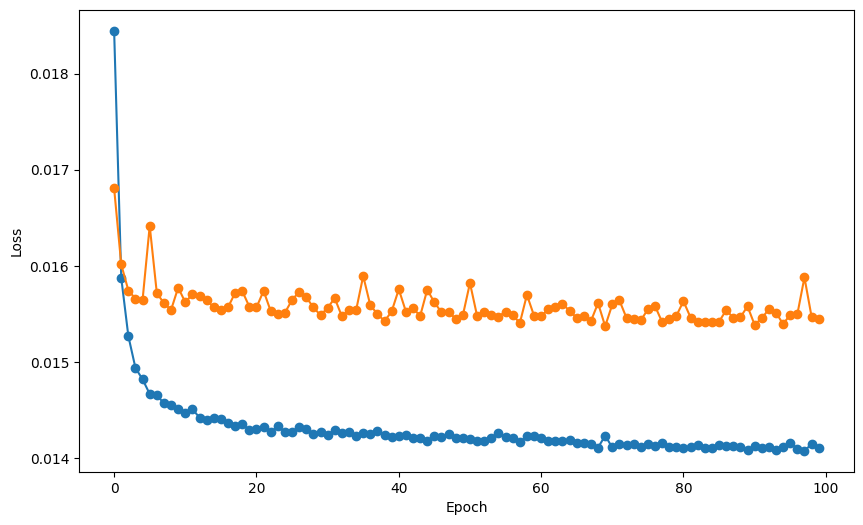

In [40]:
# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
loss_function = nn.BCEWithLogitsLoss()
"""
End of our code.
"""

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
lr_scheduler = None

# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all = [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation
    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here
    This can be done e.g. in 5 lines of code
    """
    from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

    # Assuming y_pred contains raw logits and y_true contains binary labels (0 or 1)
    # Apply sigmoid to y_pred to get probabilities for the positive class
    y_pred_prob = torch.sigmoid(torch.tensor(y_pred)).numpy()

    # Calculate metrics
    auc = roc_auc_score(y_true, y_pred_prob)
    ap = average_precision_score(y_true, y_pred_prob)

    # For F1 score, we need binary predictions. A common threshold is 0.5
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_binary)


    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth')
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                'AUROC {auc:.4f} \t'
                'AP {ap:.4f} \t'
                'F1 {f1:.4f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        auc=auc,
                        ap=ap,
                        f1=f1,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step()

"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""
plt.figure(figsize=(10, 6))
plt.plot(train_loss_all, label='Training Loss', marker='o')
plt.plot(valid_loss_all, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt

---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain soft predictions (probabilities) instead of hard predictions (0s or 1s).

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The predictions are saved in the variable `soft_pred`.
- upload your predictions to the leaderboard online (see instruction details below).

In [21]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [22]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = ModelBaseline()

# load stored model parameters
ckpt = torch.load('model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [23]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

Cloning into 'leaderboard'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Receiving objects: 100% (3/3), done.


In [24]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password.
Do not change this after you have registered your team
"""
team_id = '' #Fill in a string
password = '' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

Team registered successfully! Good luck


In [25]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = '' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

Submission successful!


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>**

Your team id: **<font color='red'>Fill in</font>**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |
|xxx              | 0        | 0  | 0   | 0  | desc                   |

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument

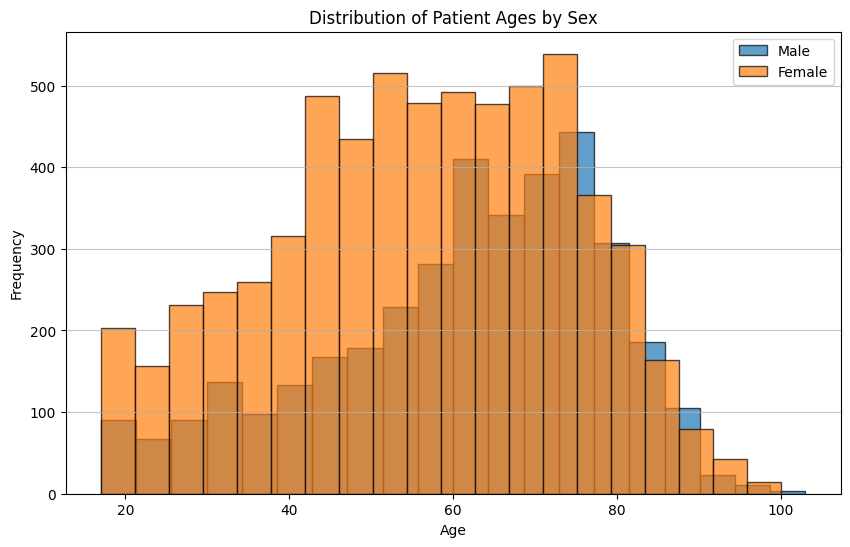

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(patient_data[patient_data['sex'] == 'M']['age'], bins=20, edgecolor='black', alpha=0.7, label='Male')
plt.hist(patient_data[patient_data['sex'] == 'F']['age'], bins=20, edgecolor='black', alpha=0.7, label='Female')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Patient Ages by Sex')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

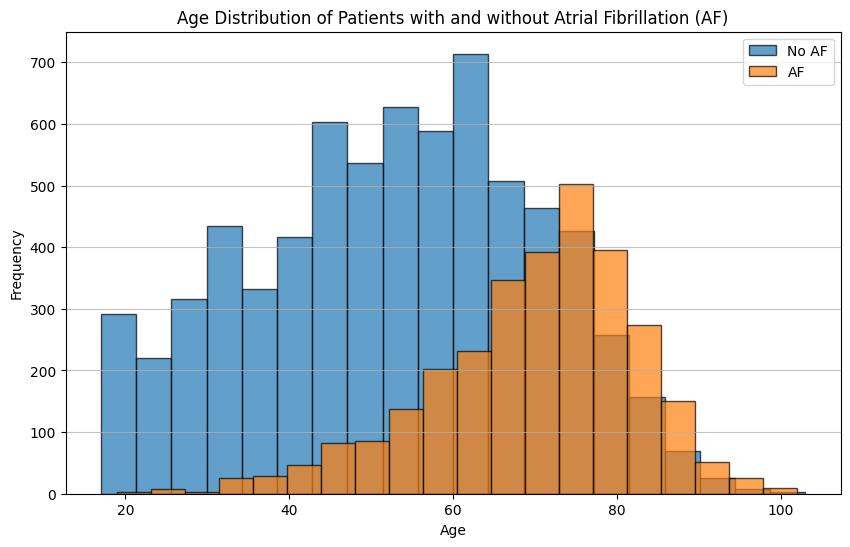

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(patient_data[patient_data['AF'] == 0]['age'], bins=20, edgecolor='black', alpha=0.7, label='No AF')
plt.hist(patient_data[patient_data['AF'] == 1]['age'], bins=20, edgecolor='black', alpha=0.7, label='AF')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution of Patients with and without Atrial Fibrillation (AF)')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

In [28]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_probs_list = []  # accumulated predicted probabilities
    valid_true_list = [] # accumulated true labels

    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code.
        """
        with torch.no_grad():
            output = model(traces)
            loss = loss_function(output, diagnoses.unsqueeze(1)) # Assuming diagnoses is a single column tensor and output is too

        # Collect true labels and predicted probabilities
        valid_true_list.append(diagnoses.cpu())
        # Assuming output is logit for binary classification, apply sigmoid to get probability for the positive class
        # If output is already probability or has multiple classes, adjust accordingly
        valid_probs_list.append(torch.sigmoid(output).squeeze(1).cpu())


        # Update accumulated values
        total_loss += loss.item() * traces.size(0)
        n_entries += traces.size(0)


        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()

    # Concatenate the lists of tensors outside the loop and convert to numpy
    valid_probs = torch.cat(valid_probs_list).numpy()
    valid_true = torch.cat(valid_true_list).numpy()


    return total_loss / n_entries, valid_probs, valid_true